# Tutorial 3: Integration of mouse embryo brain slices across different developmental stages

This tutorial demonstrates STAOmics’s ablility in cross-omics and cross-batch integration. The raw and processed data can be downloaded from the National Genomics Data Center with accession number OEP003285 and https://drive.google.com/drive/folders/1tUOEDGBrlFBsZZ0ag_pQcO_j6uELeZRk?usp=sharing, respectively.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## setting for bedtools calling in jupyter
import os
from os import path
import sys
bin_dir = path.dirname(sys.executable)
os.environ['PATH'] += os.pathsep + bin_dir
# print(os.pathsep + bin_dir)

import pandas as pd
import anndata as ad
import networkx as nx
import scanpy as sc
import STAOmics
import numpy as np
import scipy.sparse as sp
from itertools import chain

STAOmics.config.BEDTOOLS_PATH = "/mnt/disk4/xzhou/anaconda3/envs/STAOmics/bin/"

## Step 1: Data preprocessing

In [2]:
datadir = '/mnt/disk2/xzhou/code/pycharm_ATAC/STAOmics_v0/data/MISAR-seq/'

strna_e11 = ad.read_h5ad(datadir+"E11_0_RNA_raw.h5ad")
statac_e11 = ad.read_h5ad(datadir+"E11_0_ATAC_raw.h5ad")

strna_e13 = ad.read_h5ad(datadir+"E13_5_RNA_raw.h5ad")
statac_e13 = ad.read_h5ad(datadir+"E13_5_ATAC_raw.h5ad")

strna_e15 = ad.read_h5ad(datadir+"E15_5_RNA_raw.h5ad")
statac_e15 = ad.read_h5ad(datadir+"E15_5_ATAC_raw.h5ad")

strna_e18 = ad.read_h5ad(datadir+"E18_5_RNA_raw.h5ad")
statac_e18 = ad.read_h5ad(datadir+"E18_5_ATAC_raw.h5ad")

In [3]:
statac = sc.read_h5ad(datadir+"ATAC_four_stages_combined.h5ad")
statac

AnnData object with n_obs × n_vars = 7118 × 191034
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Combined_Clusters_annotation', 'ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample_name', 'array_col', 'array_row', 'Batch', 'annotation'
    obsm: 'X_lsi', 'spatial'

In [4]:
sc.pp.highly_variable_genes(strna_e11, n_top_genes=15000, flavor="seurat_v3")
sc.pp.highly_variable_genes(strna_e13, n_top_genes=15000, flavor="seurat_v3")
sc.pp.highly_variable_genes(strna_e15, n_top_genes=15000, flavor="seurat_v3")
sc.pp.highly_variable_genes(strna_e18, n_top_genes=15000, flavor="seurat_v3")

strna = ad.concat([strna_e11[:, strna_e11.var['highly_variable']], strna_e13[:, strna_e13.var['highly_variable']], 
                   strna_e15[:, strna_e15.var['highly_variable']], strna_e18[:, strna_e18.var['highly_variable']]], 
                   label="Batch", keys=['rna_e11', 'rna_e13', 'rna_e15', 'rna_e18'])
strna.var['highly_variable'] = True
print(strna.shape)

(7118, 2537)


In [5]:
statac_e18

AnnData object with n_obs × n_vars = 2129 × 117473
    obs: 'ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Combined_Clusters_annotation', 'my_annotation', 'annotation'
    var: 'features'
    uns: 'annotation_colors'
    obsm: 'X_lsi', 'X_lsi_new', 'spatial'

In [6]:
statac.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(statac, n_peak=100000, key='X_lsi')

# statac_e11.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(statac_e11, key='X_lsi')
# statac_e13.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(statac_e13, key='X_lsi')
# statac_e15.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(statac_e15, key='X_lsi')
# statac_e18.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(statac_e18, key='X_lsi')

In [7]:
STAOmics.data.get_gene_annotation(
    strna, gtf=datadir+"gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)

strna = strna[:, ~strna.var['chrom'].isna()]

In [8]:
strna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
features,,,
Rgs20,chr1,4909575.0,5070285.0
4732440D04Rik,chr1,6209865.0,6215293.0
St18,chr1,6487230.0,6860940.0
Mybl1,chr1,9667414.0,9700209.0
Prex2,chr1,10993464.0,11303681.0


In [9]:
split = statac.var_names.str.split(r"[:-]")
statac.var["chrom"] = split.map(lambda x: x[0])
statac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
statac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
statac.var.head()

,chrom,chromStart,chromEnd
features,,,
chr1-3094803-3095303,chr1,3094803,3095303
chr1-3113543-3114043,chr1,3113543,3114043
chr1-3120248-3120748,chr1,3120248,3120748
chr1-3325117-3325617,chr1,3325117,3325617
chr1-3399906-3400406,chr1,3399906,3400406


In [10]:
guidance = STAOmics.genomics.rna_anchored_guidance_graph(strna, statac, propagate_highly_variable = True)
guidance

window_graph: 100%|██████████| 2512/2512 [00:01<00:00, 2369.22it/s]


In [11]:
STAOmics.graph.check_graph(guidance, [strna, statac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [12]:
statac.var['highly_variable'].sum()

14786

In [13]:
strna.var['highly_variable'].sum()

2512

In [14]:
statac1 = statac[statac.obs['Batch'] == 'atac_e11']
statac2 = statac[statac.obs['Batch'] == 'atac_e13']
statac3 = statac[statac.obs['Batch'] == 'atac_e15']
statac4 = statac[statac.obs['Batch'] == 'atac_e18']

statac1.obsm['X_lsi'] = statac_e11.obsm['X_lsi']
statac2.obsm['X_lsi'] = statac_e13.obsm['X_lsi']
statac3.obsm['X_lsi'] = statac_e15.obsm['X_lsi']
statac4.obsm['X_lsi'] = statac_e18.obsm['X_lsi']

statac1.obs['annotation'] = statac_e11[statac1.obs_names].obs['annotation'].values
statac2.obs['annotation'] = statac_e13[statac2.obs_names].obs['annotation'].values
statac3.obs['annotation'] = statac_e15[statac3.obs_names].obs['annotation'].values
statac4.obs['annotation'] = statac_e18[statac4.obs_names].obs['annotation'].values

In [15]:
statac_e11.shape, statac_e13.shape, statac_e15.shape, statac_e18.shape

((1263, 69370), (1777, 123840), (1949, 141420), (2129, 117473))

In [16]:
strna1 = strna[strna.obs['Batch'] == 'rna_e11']
strna2 = strna[strna.obs['Batch'] == 'rna_e13']
strna3 = strna[strna.obs['Batch'] == 'rna_e15']
strna4 = strna[strna.obs['Batch'] == 'rna_e18']

In [17]:
strna1.write_h5ad(datadir + 'E11_0_RNA_pp.h5ad')
strna2.write_h5ad(datadir + 'E13_5_RNA_pp.h5ad')
strna3.write_h5ad(datadir + 'E15_5_RNA_pp.h5ad')
strna4.write_h5ad(datadir + 'E18_5_RNA_pp.h5ad')

statac1.write_h5ad(datadir + 'E11_0_ATAC_pp.h5ad')
statac2.write_h5ad(datadir + 'E13_5_ATAC_pp.h5ad')
statac3.write_h5ad(datadir + 'E15_5_ATAC_pp.h5ad')
statac4.write_h5ad(datadir + 'E18_5_ATAC_pp.h5ad')

nx.write_graphml(guidance, datadir+"mouse_embryo_guidance.graphml.gz")

## Step 2: Model training

In [18]:
strna_e11 = ad.read_h5ad(datadir+"E11_0_RNA_pp.h5ad")
statac_e11 = ad.read_h5ad(datadir+"E11_0_ATAC_pp.h5ad")

strna_e13 = ad.read_h5ad(datadir+"E13_5_RNA_pp.h5ad")
statac_e13 = ad.read_h5ad(datadir+"E13_5_ATAC_pp.h5ad")

strna_e15 = ad.read_h5ad(datadir+"E15_5_RNA_pp.h5ad")
statac_e15 = ad.read_h5ad(datadir+"E15_5_ATAC_pp.h5ad")

strna_e18 = ad.read_h5ad(datadir+"E18_5_RNA_pp.h5ad")
statac_e18 = ad.read_h5ad(datadir+"E18_5_ATAC_pp.h5ad")

guidance = nx.read_graphml(datadir+"mouse_embryo_guidance.graphml.gz")

In [19]:
strna_e11.obs_names = strna_e11.obs_names+'_rna_E11'
statac_e11.obs_names = statac_e11.obs_names+'_atac_E11'
strna_e13.obs_names = strna_e13.obs_names+'_rna_E13'
statac_e13.obs_names = statac_e13.obs_names+'_atac_E13'
strna_e15.obs_names = strna_e15.obs_names+'_rna_E15'
statac_e15.obs_names = statac_e15.obs_names+'_atac_E15'
strna_e18.obs_names = strna_e18.obs_names+'_rna_E18'
statac_e18.obs_names = statac_e18.obs_names+'_atac_E18'

In [20]:
statac_e11.layers['counts'] = statac_e11.X.copy().astype(int)
statac_e13.layers['counts'] = statac_e13.X.copy().astype(int)
statac_e15.layers['counts'] = statac_e15.X.copy().astype(int)
statac_e18.layers['counts'] = statac_e18.X.copy().astype(int)

In [21]:
strna_e11.layers['counts'] = strna_e11.X.copy().astype(int)
sc.pp.normalize_total(strna_e11) #, target_sum=1e4
sc.pp.log1p(strna_e11)
strna_e11 = strna_e11[:, strna_e11.var['highly_variable']]
strna_e11.obsm['X_feat'] = strna_e11.X.toarray()

strna_e13.layers['counts'] = strna_e13.X.copy().astype(int)
sc.pp.normalize_total(strna_e13) #, target_sum=1e4
sc.pp.log1p(strna_e13)
strna_e13 = strna_e13[:, strna_e13.var['highly_variable']]
strna_e13.obsm['X_feat'] = strna_e13.X.toarray()

strna_e15.layers['counts'] = strna_e15.X.copy().astype(int)
sc.pp.normalize_total(strna_e15) #, target_sum=1e4
sc.pp.log1p(strna_e15)
strna_e15 = strna_e15[:, strna_e15.var['highly_variable']]
strna_e15.obsm['X_feat'] = strna_e15.X.toarray()

strna_e18.layers['counts'] = strna_e18.X.copy().astype(int)
sc.pp.normalize_total(strna_e18) #, target_sum=1e4
sc.pp.log1p(strna_e18)
strna_e18 = strna_e18[:, strna_e18.var['highly_variable']]
strna_e18.obsm['X_feat'] = strna_e18.X.toarray()

In [22]:
STAOmics.utils.Cal_Spatial_Net(strna_e11, rad_cutoff=1.3)  # the spatial network are saved in adata.uns[‘adj’]
STAOmics.utils.Cal_Spatial_Net(statac_e11, rad_cutoff=1.3)

STAOmics.utils.Cal_Spatial_Net(strna_e13, rad_cutoff=1.3)  # the spatial network are saved in adata.uns[‘adj’]
STAOmics.utils.Cal_Spatial_Net(statac_e13, rad_cutoff=1.3)

STAOmics.utils.Cal_Spatial_Net(strna_e15, rad_cutoff=1.3)  # the spatial network are saved in adata.uns[‘adj’]
STAOmics.utils.Cal_Spatial_Net(statac_e15, rad_cutoff=1.3)

STAOmics.utils.Cal_Spatial_Net(strna_e18, rad_cutoff=1.3)  # the spatial network are saved in adata.uns[‘adj’]
STAOmics.utils.Cal_Spatial_Net(statac_e18, rad_cutoff=1.3)

------Calculating spatial graph...
The graph contains 4718 edges, 1263 cells.
3.7356 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 4718 edges, 1263 cells.
3.7356 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 6808 edges, 1777 cells.
3.8312 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 6808 edges, 1777 cells.
3.8312 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 7450 edges, 1949 cells.
3.8225 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 7450 edges, 1949 cells.
3.8225 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 8316 edges, 2129 cells.
3.9061 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 8316 edges, 2129 cells.
3.9061 neighbors per cell on average.


In [23]:
guidance_hvf = guidance.subgraph(chain(
    strna_e11.var.query("highly_variable").index,
    strna_e13.var.query("highly_variable").index,
    strna_e15.var.query("highly_variable").index,
    strna_e18.var.query("highly_variable").index,
    
    statac_e11.var.query("highly_variable").index,
    statac_e13.var.query("highly_variable").index,
    statac_e15.var.query("highly_variable").index,
    statac_e18.var.query("highly_variable").index
)).copy()
vertices = sorted(guidance_hvf.nodes)

In [24]:
STAOmics.models.configure_dataset(strna_e11, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_feat", use_obs_names=True)
STAOmics.models.configure_dataset(strna_e13, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_feat", use_obs_names=True)
STAOmics.models.configure_dataset(strna_e15, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_feat", use_obs_names=True)
STAOmics.models.configure_dataset(strna_e18, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_feat", use_obs_names=True)

STAOmics.models.configure_dataset(statac_e11, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_lsi", use_obs_names=True)
STAOmics.models.configure_dataset(statac_e13, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_lsi", use_obs_names=True)
STAOmics.models.configure_dataset(statac_e15, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_lsi", use_obs_names=True)
STAOmics.models.configure_dataset(statac_e18, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_lsi", use_obs_names=True)

In [25]:
model = STAOmics.models.train(
    {"rna1": strna_e11,"rna2": strna_e13, "rna3": strna_e15,"rna4": strna_e18,
     "atac1": statac_e11, "atac2": statac_e13, "atac3": statac_e15, "atac4": statac_e18}, guidance_hvf,
    fit_kws={"directory": "Mouse_embryo_r1"}, is_finetune = True, 
    OT_pair=[('rna1','atac1'),('rna2','atac2'),('rna3','atac3'),('rna4','atac4')]
    ### compile_kws={"lam_align": 0.05}
)

[INFO] train: Pretraining STAOmics model...2025-06-25 02:19:20
[INFO] autodevice: Using GPU 3 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] STAOmicsModel: Setting `graph_batch_size` = 16276
[INFO] STAOmicsModel: Setting `max_epochs` = 240
[INFO] STAOmicsModel: Setting `patience` = 20
[INFO] STAOmicsModel: Setting `reduce_lr_patience` = 10
[INFO] STAOmicsTrainer: Using training directory: "Mouse_embryo_r1/pretrain"
[INFO] STAOmicsTrainer: [Epoch 10] train={'g_nll': 0.511, 'g_kl': 0.01, 'g_elbo': 0.52, 'x_rna1_nll': 0.206, 'x_rna1_kl': 0.005, 'x_rna1_elbo': 0.211, 'x_rna2_nll': 0.257, 'x_rna2_kl': 0.005, 'x_rna2_elbo': 0.262, 'x_rna3_nll': 0.302, 'x_rna3_kl': 0.006, 'x_rna3_elbo': 0.308, 'x_rna4_nll': 0.211, 'x_rna4_kl': 0.005, 'x_rna4_elbo': 0.215, 'x_atac1_nll': 0.136, 'x_atac1_kl': 0.001, 'x_atac1_elbo': 0.138, 'x_a

2025-06-25 02:58:03,343 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "65"...
[INFO] EarlyStopping: Restoring checkpoint "65"...
[INFO] train: FGW OT mapping from source rna1 to atac1
How many source profiles were paired to an destination profile of the same cluster type: 0.7545526524148852
[INFO] train: FGW OT mapping from source rna2 to atac2
How many source profiles were paired to an destination profile of the same cluster type: 0.7878446820483962
[INFO] train: FGW OT mapping from source rna3 to atac3
How many source profiles were paired to an destination profile of the same cluster type: 0.870702924576706
[INFO] train: FGW OT mapping from source rna4 to atac4
How many source profiles were paired to an destination profile of the same cluster type: 0.7961484264913105
[INFO] train: Fine-tuning STAOmics model...2025-06-25 02:59:15
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry

2025-06-25 03:39:07,480 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "102"...
[INFO] EarlyStopping: Restoring checkpoint "102"...
[INFO] train: End of training...2025-06-25 03:39:07


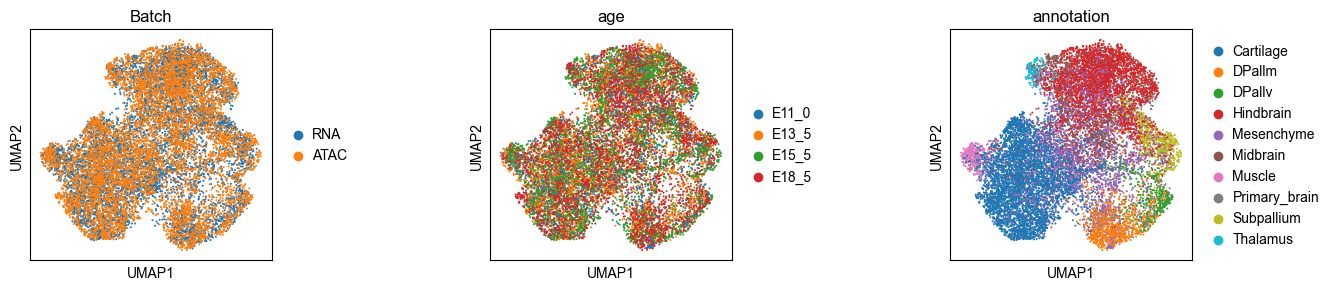

In [26]:
strna_e11.obsm["X_STAOmics"] = model.encode_data_minibatch("rna1", strna_e11)
strna_e13.obsm["X_STAOmics"] = model.encode_data_minibatch("rna2", strna_e13)
strna_e15.obsm["X_STAOmics"] = model.encode_data_minibatch("rna3", strna_e15)
strna_e18.obsm["X_STAOmics"] = model.encode_data_minibatch("rna4", strna_e18)

statac_e11.obsm["X_STAOmics"] = model.encode_data_minibatch("atac1", statac_e11)
statac_e13.obsm["X_STAOmics"] = model.encode_data_minibatch("atac2", statac_e13)
statac_e15.obsm["X_STAOmics"] = model.encode_data_minibatch("atac3", statac_e15)
statac_e18.obsm["X_STAOmics"] = model.encode_data_minibatch("atac4", statac_e18)


statac = ad.concat([statac_e11, statac_e13, statac_e15, statac_e18], label="age", keys=['E11_0','E13_5', 'E15_5', 'E18_5'])
strna = ad.concat([strna_e11, strna_e13, strna_e15, strna_e18], label="age", keys=['E11_0', 'E13_5', 'E15_5', 'E18_5'])
combined = ad.concat([strna, statac], label='Batch', keys=['RNA', 'ATAC'],join='outer')
sc.pp.neighbors(combined, use_rep="X_STAOmics", metric="cosine")
sc.tl.umap(combined)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01
fig, ax = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw={'wspace': 0.9, 'hspace': 0.1})

sc.pl.umap(combined, color=["Batch"], wspace=1, show=False, ax=ax[0])
sc.pl.umap(combined, color=["age"], wspace=1, show=False, ax=ax[1])
sc.pl.umap(combined, color=['annotation'], title='annotation', show=False, ax=ax[2])   #, legend_loc=None
plt.show()

In [27]:
sc.tl.leiden(combined, random_state=666, key_added="leiden", resolution=0.7)

strna_e11.obs['leiden'] = combined.obs['leiden'][np.array(combined.obs['Batch'] == 'RNA') & np.array(combined.obs['age'] == 'E11_0')].values
strna_e13.obs['leiden'] = combined.obs['leiden'][np.array(combined.obs['Batch'] == 'RNA') & np.array(combined.obs['age'] == 'E13_5')].values
strna_e15.obs['leiden'] = combined.obs['leiden'][np.array(combined.obs['Batch'] == 'RNA') & np.array(combined.obs['age'] == 'E15_5')].values
strna_e18.obs['leiden'] = combined.obs['leiden'][np.array(combined.obs['Batch'] == 'RNA') & np.array(combined.obs['age'] == 'E18_5')].values

statac_e11.obs['leiden'] = combined.obs['leiden'][np.array(combined.obs['Batch'] == 'ATAC') & np.array(combined.obs['age'] == 'E11_0')].values
statac_e13.obs['leiden'] = combined.obs['leiden'][np.array(combined.obs['Batch'] == 'ATAC') & np.array(combined.obs['age'] == 'E13_5')].values
statac_e15.obs['leiden'] = combined.obs['leiden'][np.array(combined.obs['Batch'] == 'ATAC') & np.array(combined.obs['age'] == 'E15_5')].values
statac_e18.obs['leiden'] = combined.obs['leiden'][np.array(combined.obs['Batch'] == 'ATAC') & np.array(combined.obs['age'] == 'E18_5')].values

In [28]:
## optional refinement step for a few outlier spots
for adata in [strna_e11,strna_e13,strna_e15,strna_e18, statac_e11,statac_e13,statac_e15,statac_e18]:
    clusters = adata.obs["leiden"].values.astype(int).copy()
    adata = STAOmics.utils.cluster_post_process(adata, clutser_result = clusters, key_added = "refine_cluster")


Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, run times: 3/3

Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, run times: 3/3

Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, run times: 3/3

Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, run times: 3/3

Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, run times: 3/3

Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, run times: 3/3

Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, 

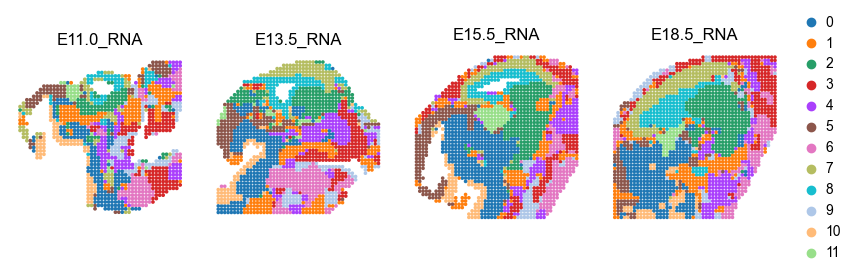

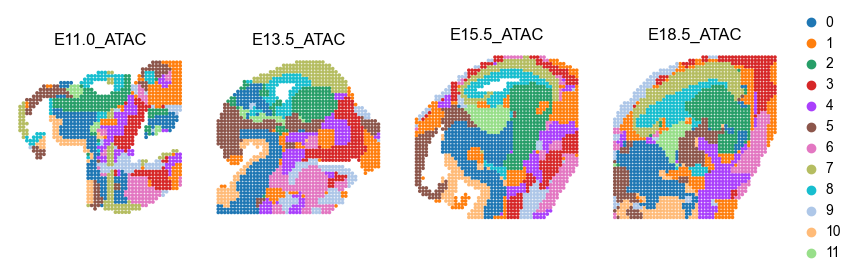

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01

spot_size = 1.1
fig, ax = plt.subplots(1, 4, figsize=(10, 3), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
sc.pl.spatial(strna_e11, color='refine_cluster', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title='E11.0_RNA', ax=ax[0], legend_loc=None)
sc.pl.spatial(strna_e13, color='refine_cluster', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title='E13.5_RNA', ax=ax[1], legend_loc=None)
sc.pl.spatial(strna_e15, color='refine_cluster', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title='E15.5_RNA', ax=ax[2], legend_loc=None)
sc.pl.spatial(strna_e18, color='refine_cluster', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title='E18.5_RNA', ax=ax[3]) #, legend_loc=None
plt.show()

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10
spot_size = 1.1
fig, ax = plt.subplots(1, 4, figsize=(10, 3), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
sc.pl.spatial(statac_e11, color='refine_cluster', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title='E11.0_ATAC', ax=ax[0], legend_loc=None)
sc.pl.spatial(statac_e13, color='refine_cluster', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title='E13.5_ATAC', ax=ax[1], legend_loc=None)
sc.pl.spatial(statac_e15, color='refine_cluster', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title='E15.5_ATAC', ax=ax[2], legend_loc=None)
sc.pl.spatial(statac_e18, color='refine_cluster', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title='E18.5_ATAC', ax=ax[3]) #, legend_loc=None
plt.show()